### **Text Mining and Natural Language Processing**

**Text Mining**

*Extracting .txt files from a folder*

In [1]:
import glob

path = r'Tel_text/*.txt'
files = glob.glob(path)

file_contents = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        file_contents.append(f.read())

*Combining english and french stopwords*

In [2]:
from nltk.corpus import stopwords

try:
    stop_words_en = stopwords.words('english')  
    stop_words_fr = stopwords.words('french')  
except LookupError:
    nltk.download('stopwords')
    stop_words_en = stopwords.words('english')  
    stop_words_fr = stopwords.words('french')  

combined_stop_words = stop_words_en + stop_words_fr

#remove duplicates using set()
combined_stop_words = list(set(combined_stop_words))

print(combined_stop_words[:10])

['les', 'needn', 'by', 'qu', 'off', 'est', 'his', 'étions', 'fusses', 'ayant']


*Detect Language of each thesis*

In [3]:
import os
from langdetect import detect_langs, DetectorFactory
import pandas as pd
import re
from collections import Counter

folder_path = "Tel_text"

results = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
            
            # Preprocess
            content = re.sub(r'[^\w\s]', ' ', content)  # Remove special characters
            content = re.sub(r'\s+', ' ', content).strip()  # Normalize whitespace
            
            # Extract contents and joins all line
            content_lines = content.splitlines()
            main_content = " ".join(content_lines[:]) 
            if not main_content.strip():  #removes whitespace
                main_content = content
            
            snippet = main_content[:200].replace("\n", " ").strip()
            
            detected_languages = detect_langs(main_content[:]) 
            language_counts = Counter(lang.lang for lang in detected_languages)
            detected_language = language_counts.most_common(1)[0][0]
            
            # Log ambiguous results if confidence is low
            confidence = detected_languages[0].prob if detected_languages else 0
            if confidence < 0.75:
                detected_language = f"Ambiguous ({detected_language})"
            
            results.append({
                "File Name": file_name,
                "Detected Language": detected_language,
                "Confidence": confidence,
                "Snippet": snippet,
                "Mixed Languages": ", ".join([f"{lang.lang} ({lang.prob:.2f})" for lang in detected_languages])
            })
        except Exception as e:
            results.append({
                "File Name": file_name,
                "Detected Language": f"Error: {str(e)}",
                "Confidence": "N/A",
                "Snippet": "N/A",
                "Mixed Languages": "N/A"
            })

lang_detect = pd.DataFrame(results)
lang_detect.head()

,File Name,Detected Language,Confidence,Snippet,Mixed Languages
0,tel-03435883.txt,fr,0.999997,Les systèmes Toxine Antitoxine VapBC des régul...,fr (1.00)
1,tel-03435884.txt,fr,0.999997,Étude phylogénique de souches d alphaherpèsvir...,fr (1.00)
2,tel-03435885.txt,fr,0.857142,Multi scale studies of Measeles virus nucleoca...,"fr (0.86), en (0.14)"
3,tel-03435936.txt,fr,0.999998,Caractérisation génomique des anomalies de la ...,fr (1.00)
4,tel-03436011.txt,fr,0.999995,Le Conseil économique social et environnementa...,fr (1.00)


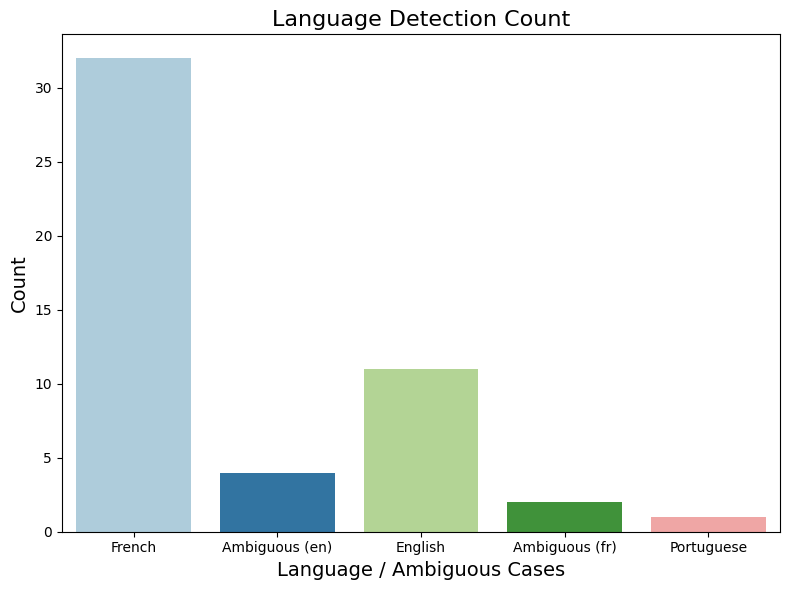

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

category_labels = {
    "fr": "French",
    "en": "English",
    "Ambiguous (en)": "Ambiguous (en)",
    "Ambiguous (fr)": "Ambiguous (fr)",
    "pt": "Portuguese"
}

lang_detect['Detected Language'] = lang_detect['Detected Language'].map(category_labels)


plt.figure(figsize=(8, 6))
sns.countplot(lang_detect, x = "Detected Language", hue= "Detected Language", palette="Paired")

plt.title("Language Detection Count", fontsize=16)
plt.xlabel("Language / Ambiguous Cases", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk

folder_path = "Tel_text"

#Define stopwords for languages
languages = ["English", "French","Portuguese"]
stopwords_dict = {lang: set(stopwords.words(lang)) for lang in languages}

results = []
def detect_language_with_stopwords(text):
    #Tokenize and make it lowercase
    word_list = re.findall(r'\b\w+\b', text.lower())  
    word_counts = Counter(word_list)
    
    #Count overlap with stopwords for each language
    language_matches = {
        lang: sum(word_counts[word] for word in stopwords_dict[lang])
        for lang in stopwords_dict
    }
    
    #Detect the language with the highest overlap
    detected_lang = max(language_matches, key=language_matches.get)
    max_overlap = language_matches[detected_lang]
    
    return detected_lang, max_overlap, language_matches

#Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        try:
            #Read the content of the file
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
            
            #Preprocess the content
            content = re.sub(r'[^\w\s]', ' ', content)  # Remove special characters
            content = re.sub(r'\s+', ' ', content).strip()  # Normalize whitespace
            
            #To Detect the language
            detected_lang, max_overlap, language_matches = detect_language_with_stopwords(content)
            
            #Extract snippet for reference
            snippet = content[:].replace("\n", " ").strip()
            
            #Append results
            results.append({
                "File Name": file_name,
                "Detected Language": detected_lang,
                "Max Overlap": max_overlap,
                "Language Matches": language_matches,
                "Snippet": snippet,
            })
        except Exception as e:
            results.append({
                "File Name": file_name,
                "Detected Language": f"Error: {str(e)}",
                "Max Overlap": "N/A",
                "Language Matches": "N/A",
                "Snippet": "N/A",
            })

df = pd.DataFrame(results)
df.head()

,File Name,Detected Language,Max Overlap,Language Matches,Snippet
0,tel-03435883.txt,French,27900,"{'English': 12780, 'French': 27900, 'Portugues...",Les systèmes Toxine Antitoxine VapBC des régul...
1,tel-03435884.txt,French,33856,"{'English': 20745, 'French': 33856, 'Portugues...",Étude phylogénique de souches d alphaherpèsvir...
2,tel-03435885.txt,English,25626,"{'English': 25626, 'French': 5370, 'Portuguese...",Multi scale studies of Measeles virus nucleoca...
3,tel-03435936.txt,French,13528,"{'English': 11359, 'French': 13528, 'Portugues...",Caractérisation génomique des anomalies de la ...
4,tel-03436011.txt,French,63485,"{'English': 5360, 'French': 63485, 'Portuguese...",Le Conseil économique social et environnementa...


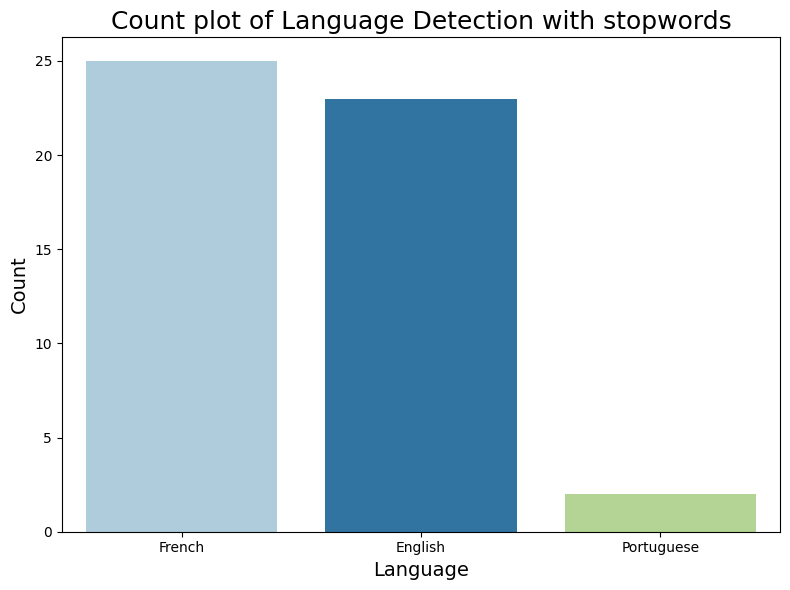

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(df, x = "Detected Language", hue= "Detected Language", palette="Paired")

plt.title("Count plot of Language Detection with stopwords", fontsize=18)
plt.xlabel("Language", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

*TF-IDF Vectorization*

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVect = TfidfVectorizer(input="content", stop_words=combined_stop_words, smooth_idf=True, norm='l2')
tfidf_matrix = TfidfVect.fit_transform(file_contents)

TF-IDF vectorization converts the text into numerical representations using TF-IDF. Preprocessing (converting text to lowercase and removing stopwords) is done within TfidfVectorizer.

tfidf_matrix contains the TF-IDF score of terms for the documents (columns - terms , rows - documents).

*Cosine Similarity*

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)

Measures pairwise similarity between the documents based on the tfidf_matrix

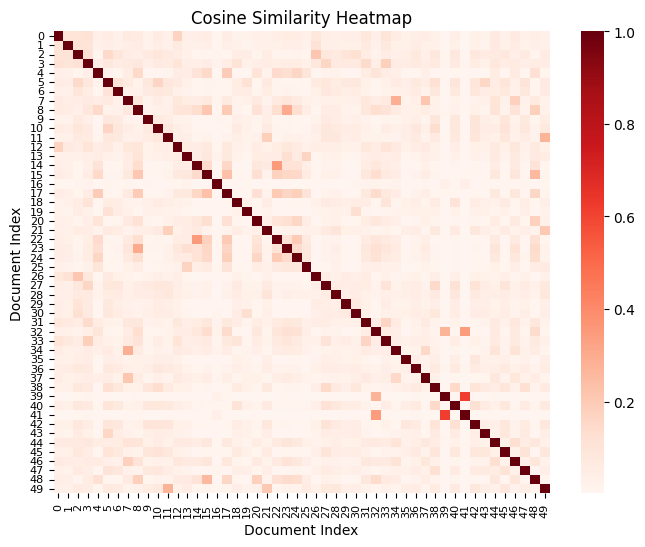

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim, annot=False, cmap="Reds", 
            xticklabels=range(cosine_sim.shape[0]), 
            yticklabels=range(cosine_sim.shape[0]))

plt.title("Cosine Similarity Heatmap")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.show()

*Extracting top words and TF-IDF scores for each file*

In [10]:
import pandas as pd

feature_names = TfidfVect.get_feature_names_out() 

top_words_data = []  
top_scores_data = [] 

for idx, file in enumerate(files[:10]):
    #Get the TF-IDF scores for the current file
    file_tfidf = tfidf_matrix[idx].toarray()[0]  
    #Pair all the words with their scores
    scores = list(zip(feature_names, file_tfidf))  
    #Get the top 5 words and scores
    top_words_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]  
    
    top_words_data.append([word for word, score in top_words_and_scores])
    top_scores_data.append([score for word, score in top_words_and_scores])

#Convert to DataFrames
words_df = pd.DataFrame(top_words_data, columns=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'], index=[f"File {i+1}" for i in range(len(top_words_data))])
scores_df = pd.DataFrame(top_scores_data, columns=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'], index=[f"File {i+1}" for i in range(len(top_scores_data))])

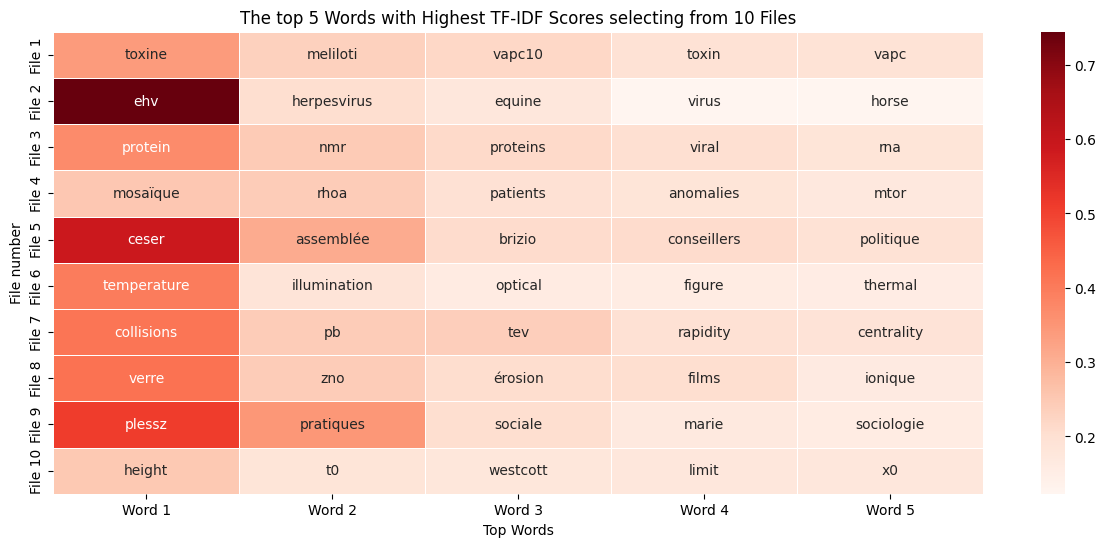

In [11]:
plt.figure(figsize=(15, 6))
sns.heatmap(scores_df, annot=words_df, fmt='', cmap='Reds', linewidths=0.5, cbar=True)

plt.title('The top 5 Words with Highest TF-IDF Scores selecting from 10 Files')
plt.xlabel('Top Words')
plt.ylabel('File number')

plt.show()

*Bigrams*

In [12]:
TfidfVect_bigram = TfidfVectorizer(input="content", stop_words=combined_stop_words, ngram_range=(2,2), smooth_idf=True, norm='l2')
tfidf_matrix_bigram = TfidfVect_bigram.fit_transform(file_contents)
cosine_sim_bigram = cosine_similarity(tfidf_matrix_bigram,tfidf_matrix_bigram)

feature_names_bigram = TfidfVect_bigram.get_feature_names_out() 

top_bigrams_data = []  
top_bigrams_scores_data = [] 

for idx, file in enumerate(files[:10]):
    #Get the TF-IDF scores for the current file
    file_tfidf = tfidf_matrix_bigram[idx].toarray()[0]  
    #Pairs all the words with their scores
    scores = list(zip(feature_names_bigram, file_tfidf))  
    #Gets the top 5 words and scores
    top_bigrams_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]  
    
    top_bigrams_data.append([word for word, score in top_bigrams_and_scores])
    top_bigrams_scores_data.append([score for word, score in top_bigrams_and_scores])

bigram_df = pd.DataFrame(top_bigrams_data, columns=['Bigram 1', 'Bigram 2', 'Bigram 3', 'Bigram 4', 'Bigram 5'], index=[f"File {i+1}" for i in range(len(top_bigrams_data))])
bigram_scores_df = pd.DataFrame(top_bigrams_scores_data, columns=['Bigram 1', 'Bigram 2', 'Bigram 3', 'Bigram 4', 'Bigram 5'], index=[f"File {i+1}" for i in range(len(top_bigrams_scores_data))])

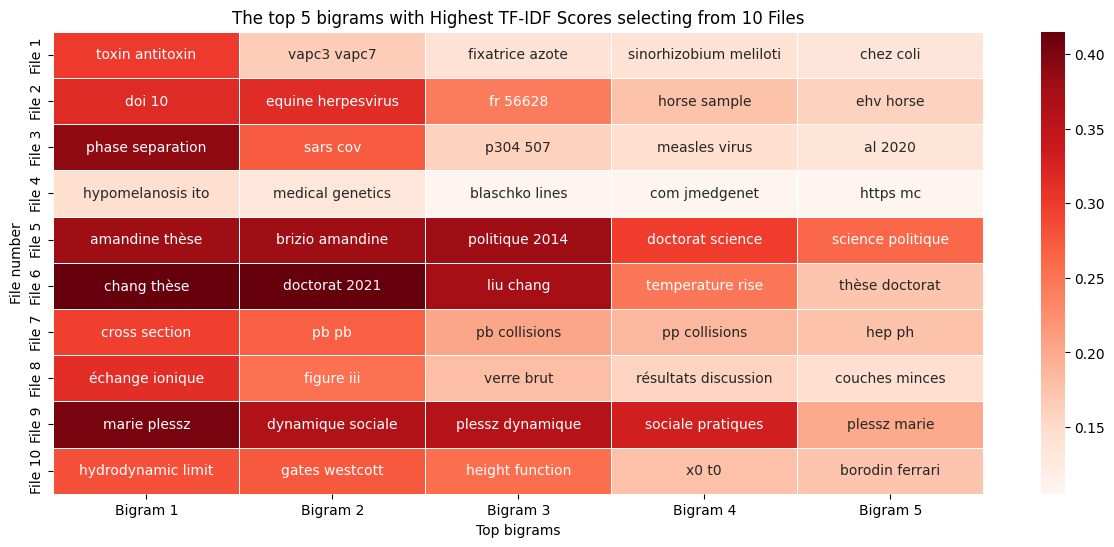

In [13]:
plt.figure(figsize=(15, 6))
sns.heatmap(bigram_scores_df, annot=bigram_df, fmt='', cmap='Reds', linewidths=0.5, cbar=True)

plt.title('The top 5 bigrams with Highest TF-IDF Scores selecting from 10 Files')
plt.xlabel('Top bigrams')
plt.ylabel('File number')
plt.show()

*Trigrams*

In [14]:
TfidfVect_trigram = TfidfVectorizer(input="content", stop_words=combined_stop_words, ngram_range=(3,3), smooth_idf=True, norm='l2')
tfidf_matrix_trigram = TfidfVect_trigram.fit_transform(file_contents)
cosine_sim_trigram = cosine_similarity(tfidf_matrix_trigram, tfidf_matrix_trigram)

feature_names_trigram = TfidfVect_trigram.get_feature_names_out()

top_trigrams_data = []  
top_trigrams_scores_data = [] 

for idx, file in enumerate(files[:10]):
    file_tfidf = tfidf_matrix_trigram[idx].toarray()[0]
    scores = list(zip(feature_names_trigram, file_tfidf))
    top_trigrams_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]
    
    top_trigrams_data.append([word for word, score in top_trigrams_and_scores])
    top_trigrams_scores_data.append([score for word, score in top_trigrams_and_scores])

trigram_df = pd.DataFrame(top_trigrams_data, columns=['Trigram 1', 'Trigram 2', 'Trigram 3', 'Trigram 4', 'Trigram 5'], index=[f"File {i+1}" for i in range(len(top_trigrams_data))])
trigram_scores_df = pd.DataFrame(top_trigrams_scores_data, columns=['Trigram 1', 'Trigram 2', 'Trigram 3', 'Trigram 4', 'Trigram 5'], index=[f"File {i+1}" for i in range(len(top_trigrams_scores_data))])


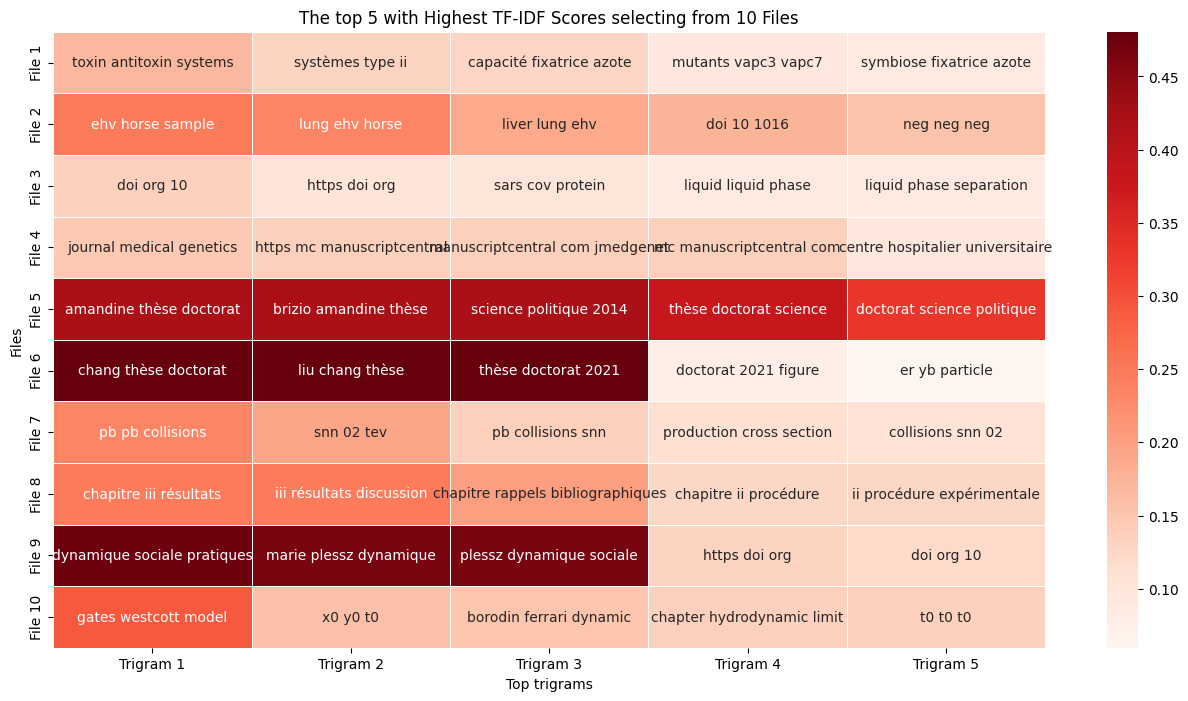

In [15]:
plt.figure(figsize=(16, 8))
sns.heatmap(trigram_scores_df, annot=trigram_df, fmt='', cmap='Reds', linewidths=0.5, cbar=True)

plt.title('The top 5 with Highest TF-IDF Scores selecting from 10 Files')
plt.xlabel('Top trigrams')
plt.ylabel('Files')
plt.show()  

In [16]:
combined_trigrams = [] 
combined_scores = []

for trigrams, scores in zip(top_trigrams_data, top_trigrams_scores_data):
    combined_trigrams.extend(trigrams)
    combined_scores.extend(scores)

data = pd.DataFrame({"Trigram": combined_trigrams, "TF-IDF Score": combined_scores})

#Group by trigram to get their cumulative score across all files
aggregated_data = data.groupby("Trigram", as_index=False).sum()

#Sort by TF-IDF scores in descending order and take the top 10
top_10_trigrams = aggregated_data.sort_values(by="TF-IDF Score", ascending=False).head(10)


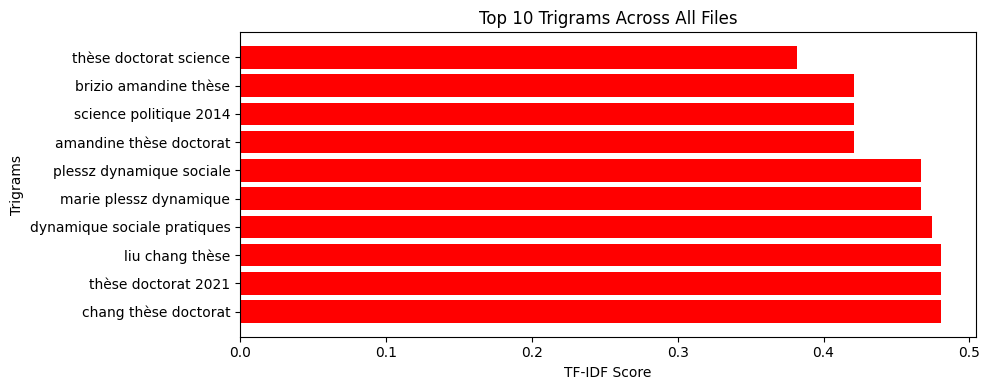

In [17]:
plt.figure(figsize=(10, 4))
plt.barh(top_10_trigrams["Trigram"], top_10_trigrams["TF-IDF Score"], color="red")

plt.xlabel("TF-IDF Score")
plt.ylabel("Trigrams")
plt.title("Top 10 Trigrams Across All Files")
plt.tight_layout()
plt.show()

Bigram is faster compared to trigram as in bigram uses smaller combinatons.
Bigram gives the word pairs that can indicate general topic or field (e.g., equine herpesvirus, politique 2014, temperature rise, etc...).
Trigram has greater specificity (lung ehv horse, science politique 2014,  er yb particle, etc...).
Bigrams could highlight general fields in the phD while Trigrams could highlights subfields.

*Forced Directed Graph*

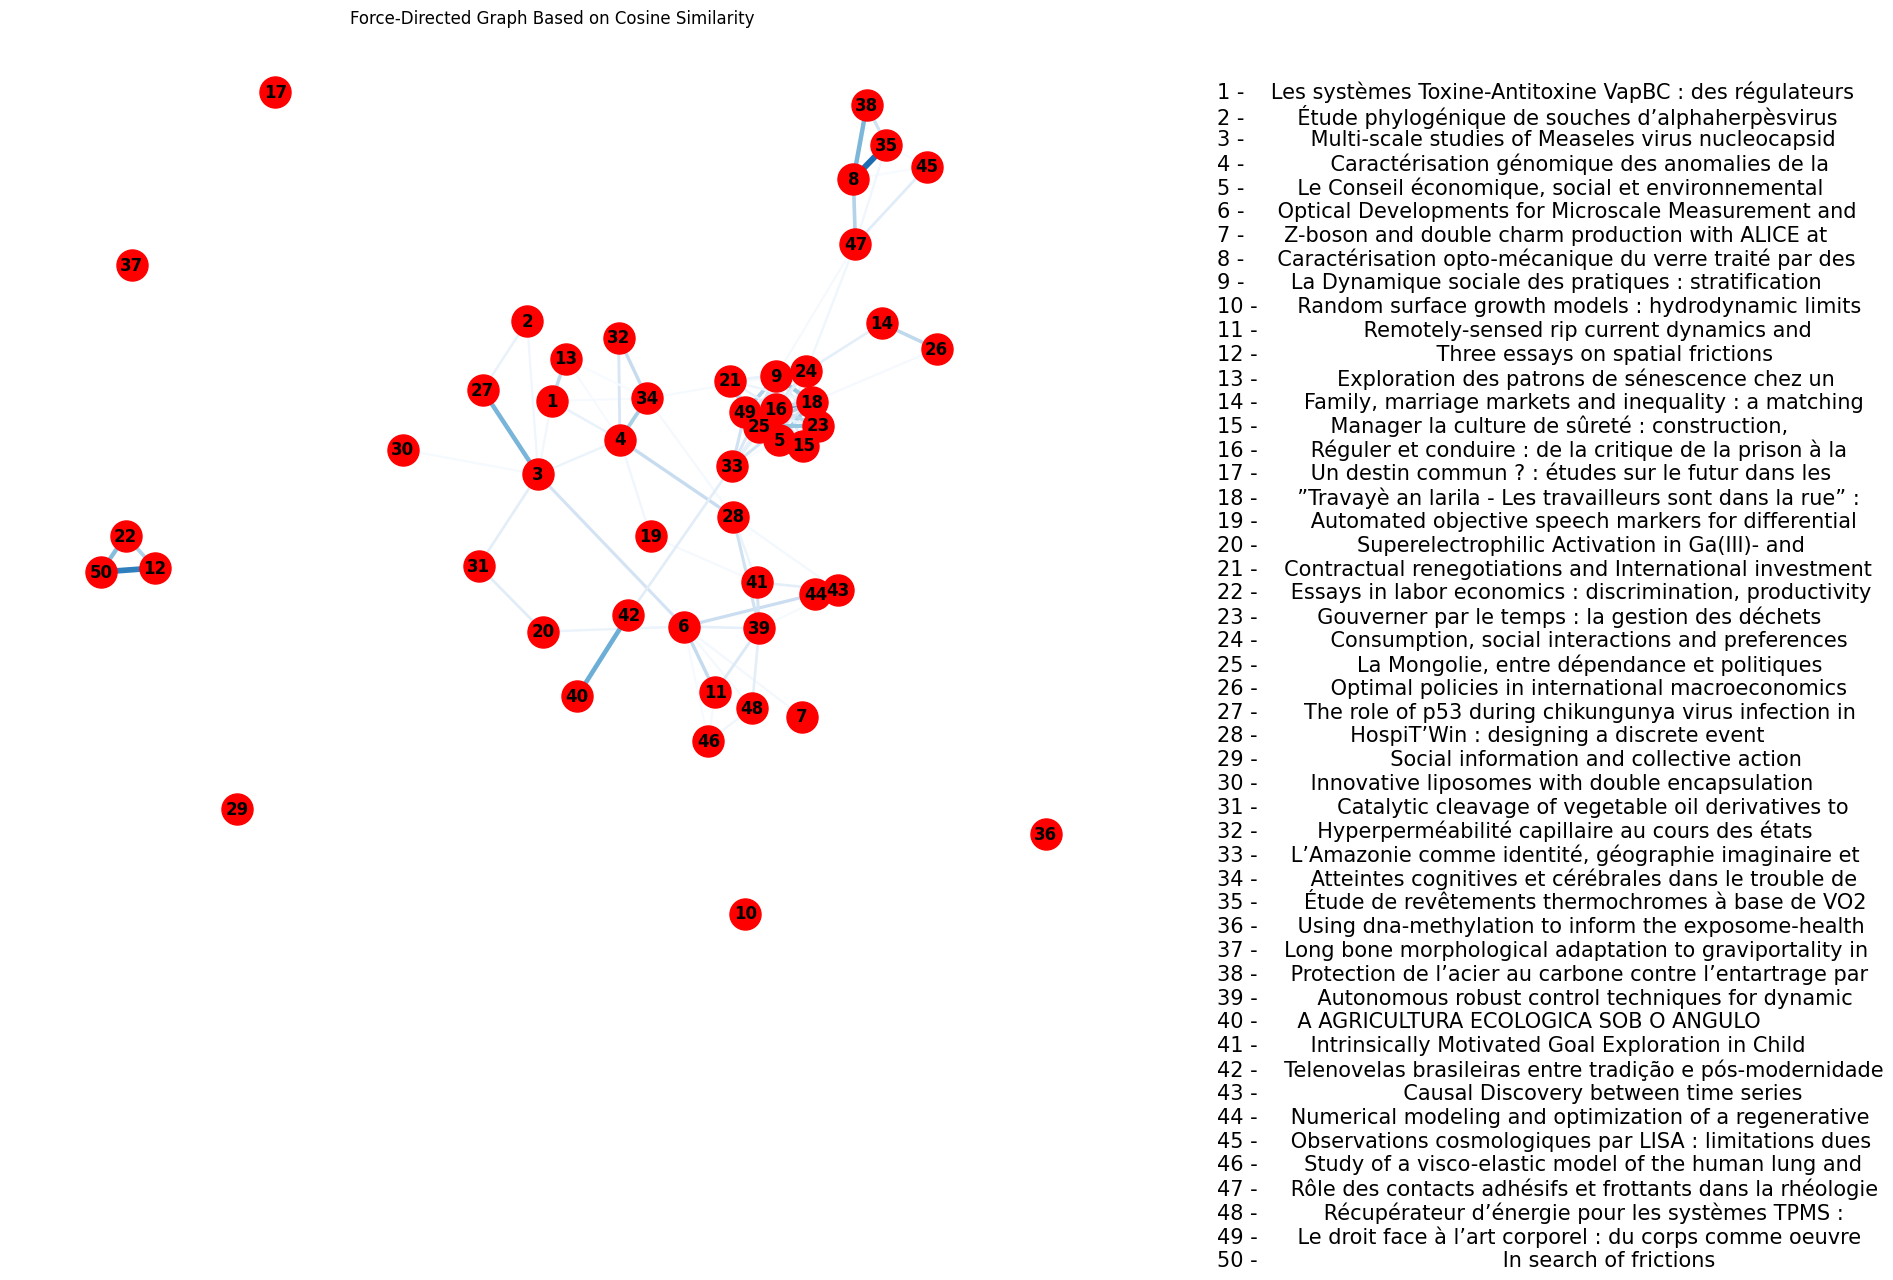

In [18]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
import re
from nltk.corpus import stopwords

#Define stopwords for languages
stop_words = stopwords.words("english") + stopwords.words("french") + stopwords.words("portuguese")

#Initialize the TfidfVectorizer to extract bigrams (using ngram_range=(2, 2))
tfidf_vectorizer_bigram = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, norm='l2')

path = r'Tel_text/*.txt'
txt_files = glob.glob(path)

file_to_title = {}

#To extract the first line of content as the title
def extract_title(content):
    return content.splitlines()[0] if content else "No Title"

for file in txt_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            file_to_title[file] = extract_title(content)
    except FileNotFoundError:
        print(f"Warning: File not found - {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

#Read documents, calculate TF-IDF bigram matrix and cosine similiarity
documents = [open(file, "r", encoding="utf-8").read() for file in txt_files]
tfidf_matrix_bigram = tfidf_vectorizer_bigram.fit_transform(documents)
cosine_sim = cosine_similarity(tfidf_matrix_bigram, tfidf_matrix_bigram)

G = nx.Graph()

#Add nodes using titles instead of file names
for file in txt_files:
    title = file_to_title.get(file, "Unknown Title")  # Default to "Unknown Title" if no title is found
    G.add_node(title)

#Add edges based on cosine similarity 
threshold = 0.1 
for i in range(len(txt_files)):
    for j in range(i + 1, len(txt_files)):
        if cosine_sim[i, j] > threshold:  # If similarity is above threshold it add an edge
            G.add_edge(file_to_title[txt_files[i]], file_to_title[txt_files[j]], weight=cosine_sim[i, j])

#Sort tif we cant to get most connected nodes
node_degrees = dict(G.degree())  # Get the degree for each node
sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True) 

#To visualize all thesis topics I am using all the nodes, To visualize only few connected nodes, add value in [:] (e.g.,[:20])
top_n_titles = [node for node, degree in sorted_nodes_by_degree[:]]

#Subgraph with the selected top 10 nodes
G_sub = G.subgraph(top_n_titles).copy()

#Assign numbers to the nodes
node_labels = {node: str(i + 1) for i, node in enumerate(G_sub.nodes)}

pos = nx.spring_layout(G_sub, seed=42)

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color="red")

#Get the edge weights (cosine similarity scores) for coloring edges
edge_colors = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
#Scale the width of edges based on the weight (cosine similarity)
edge_widths = [G_sub[u][v]['weight'] * 15 for u, v in G_sub.edges()]

#Normalize edge colors to a range from 0 to 1
norm = plt.Normalize(min(edge_colors), max(edge_colors))
cmap = plt.get_cmap('Blues')

nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap)

#Draw labels with numbers
nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=12, font_weight="bold")

#Adjust the layout for the titles outside the plot
x_offset = 1 
y_offset = 0.8 

for i, title in enumerate(G_sub.nodes):  # Loop through nodes in the subgraph
    # Find corresponding node number
    node_num = node_labels[title]
    plt.text(x_offset, y_offset - 0.05 * i, f"{node_num} - {title}", fontsize=15, ha="left", va="center")

plt.title(f"Force-Directed Graph Based on Cosine Similarity")
plt.axis("off")
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


We can see all the connections formed and when we analyse closely, we can see that the Clusters 12, 22 and 50 are all topics related to economics hence why they are all connected. Furthermore we can observe that the middle clusters mainly focus on both biology and social science, while the clusters on top right has thesis on topics related to physics. We can also observe there are some isolated nodes such as cluster number 36, 10, 29, 37 and 17  which have no connection with any other nodes.

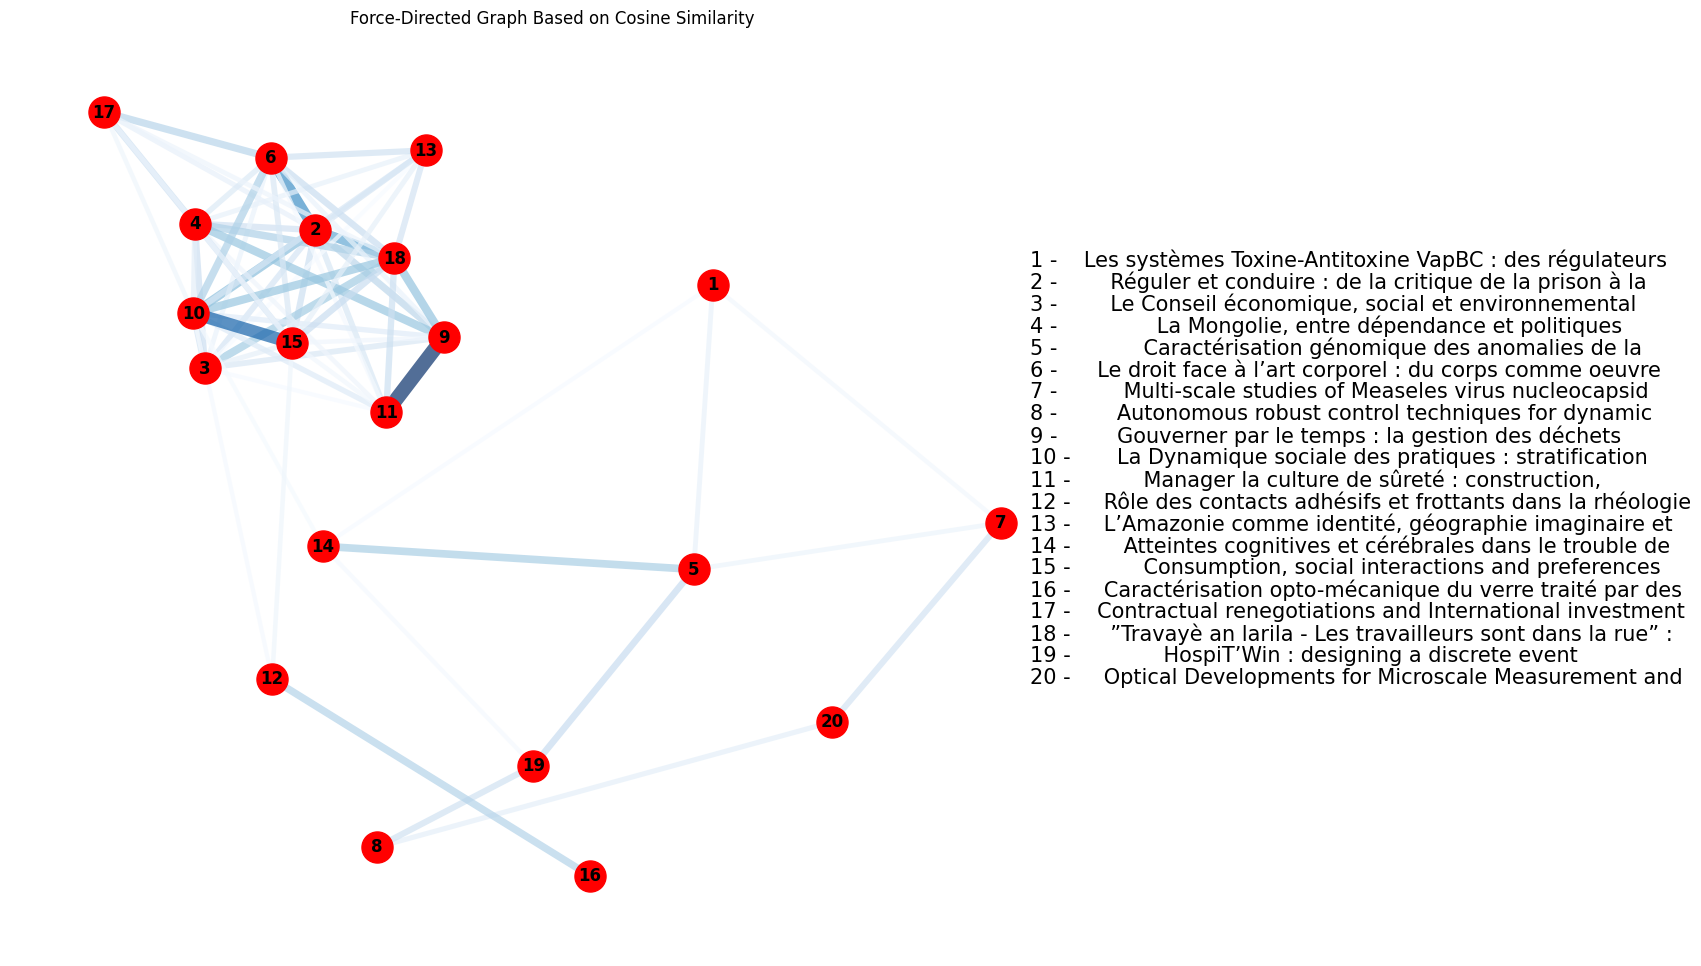

In [19]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
import re
from nltk.corpus import stopwords

stop_words = stopwords.words("english") + stopwords.words("french") + stopwords.words("portuguese")

tfidf_vectorizer_bigram = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, norm='l2')

path = r'Tel_text/*.txt'
txt_files = glob.glob(path)

file_to_title = {}

def extract_title(content):
    return content.splitlines()[0] if content else "No Title"

for file in txt_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            file_to_title[file] = extract_title(content)
    except FileNotFoundError:
        print(f"Warning: File not found - {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

documents = [open(file, "r", encoding="utf-8").read() for file in txt_files]
tfidf_matrix_bigram = tfidf_vectorizer_bigram.fit_transform(documents)
cosine_sim = cosine_similarity(tfidf_matrix_bigram, tfidf_matrix_bigram)

G = nx.Graph()

for file in txt_files:
    title = file_to_title.get(file, "Unknown Title")  
    G.add_node(title)

threshold = 0.1 
for i in range(len(txt_files)):
    for j in range(i + 1, len(txt_files)):
        if cosine_sim[i, j] > threshold:  
            G.add_edge(file_to_title[txt_files[i]], file_to_title[txt_files[j]], weight=cosine_sim[i, j])

node_degrees = dict(G.degree())  
sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True) 

top_n_titles = [node for node, degree in sorted_nodes_by_degree[:20]]

G_sub = G.subgraph(top_n_titles).copy()

node_labels = {node: str(i + 1) for i, node in enumerate(G_sub.nodes)}

pos = nx.spring_layout(G_sub,  seed=42, scale=2, k=0.5)

plt.figure(figsize=(14, 12), facecolor="white")

nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color="red")

edge_colors = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
edge_widths = [G_sub[u][v]['weight'] * 30 for u, v in G_sub.edges()] 

norm = plt.Normalize(min(edge_colors), max(edge_colors))
cmap = plt.get_cmap('Blues') 

nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap, alpha=0.7)

nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=12, font_weight="bold")

x_offset = 2.1
y_offset = 0.8  

for i, title in enumerate(G_sub.nodes):  
    node_num = node_labels[title]
    plt.text(x_offset, y_offset - 0.1 * i, f"{node_num} - {title}", fontsize=15, ha="left", va="center")

plt.title(f"Force-Directed Graph Based on Cosine Similarity")
plt.axis("off")
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

### **POS-tagging**

In [ ]:
import spacy
import pandas as pd
import random

#SpaCy's English model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Model 'en_core_web_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
#note: file path may need to be modified depending on where it is saved
file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

#Ensure the data has an English column
if "English" not in df.columns:
    raise ValueError("No 'English' column found in the sheet!")

#Function to extract noun and pronoun details
def extract_noun_pronoun_details(sentence):
    #Process the sentence
    doc = nlp(sentence)  
    details = {
        "nouns": [],
        "pronouns": []
    }
    
    for token in doc:
        #Identify nouns
        if token.pos_ == "NOUN":  
            details["nouns"].append({
                "word": token.text,
                "position": token.i
            })
        #Identify pronouns
        elif token.pos_ == "PRON":  
            details["pronouns"].append({
                "word": token.text,
                "position": token.i
            })
    
    return details

#Apply the extraction function to the English sentences
df["Noun_Pronoun_Details"] = df["English"].apply(
    lambda x: extract_noun_pronoun_details(x) if isinstance(x, str) else {"nouns": [], "pronouns": []}
)

#Prepare data for saving extracted nouns and pronouns
noun_pronoun_data = []
for index, row in df.iterrows():
    for noun in row["Noun_Pronoun_Details"]["nouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["English"],
            "word": noun["word"],
            "part_of_speech": "NOUN",
            "position": noun["position"]
        })
    for pronoun in row["Noun_Pronoun_Details"]["pronouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["English"],
            "word": pronoun["word"],
            "part_of_speech": "PRONOUN",
            "position": pronoun["position"]
        })

noun_pronoun_df = pd.DataFrame(noun_pronoun_data)

#note to self: saved to my personal file but can be modified
noun_pronoun_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\Extracted_Nouns_Pronouns_English.xlsx"
noun_pronoun_df.to_excel(noun_pronoun_output_path, index=False)

print(f"Extracted Nouns and Pronouns saved to {noun_pronoun_output_path}")

#MCQs for identifying nouns and pronouns
def generate_mcq(row):
    try:
        #Extract words from the sentence in this case get first 5 words
        words_in_sentence = row["sentence"].split()[:5] 
        
        #Randomize for MCQ
        options = random.sample(words_in_sentence, len(words_in_sentence))
        
        #Determine the question type (NOUN or PRONOUN)
        correct_pos = row["part_of_speech"]
        question_type = "pronoun" if correct_pos == "PRONOUN" else "noun"
        
        mcq = {
            "question": f"Which of the following words is a {question_type}? ({', '.join(words_in_sentence)})",
            "options": ", ".join(options),
            "correct_answer": row["word"]
        }
        return mcq
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
        return None

#Generate MCQs for nouns and pronouns
mcq_data = []
for _, row in noun_pronoun_df.iterrows():
    mcq = generate_mcq(row)
    if mcq:
        mcq_data.append(mcq)

#New DataFrame for the generated MCQs
mcq_df = pd.DataFrame(mcq_data)

#Note: saved to my personal location but can modify it
mcq_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\MCQs in English.xlsx"
mcq_df.to_excel(mcq_output_path, index=False)

print(f"MCQs for Nouns and Pronouns saved to {mcq_output_path}")


Extracted Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\Extracted_Nouns_Pronouns.xlsx
MCQs for Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\MCQs in English.xlsx


In [ ]:
import spacy
import pandas as pd
import random

#SpaCy's German model
try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Model 'de_core_news_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("de_core_news_sm")
    nlp = spacy.load("de_core_news_sm")

#note to self: file path set to my personal but can be changed
file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

#Check data has a column called German
if "German" not in df.columns:
    raise ValueError("No 'German' column found in the sheet!")

#Function to extract noun details
def extract_noun_details(sentence):
    #Process the sentence
    doc = nlp(sentence)  
    details = []
    for token in doc:
        #Identify nouns
        if token.pos_ == "NOUN":  
            details.append({
                "noun": token.text,
                "gender": token.morph.get("Gender", [None])[0],
                "case": token.morph.get("Case", [None])[0],
                "position": token.i
            })
    return details

#Add noun details to the DataFrame
df["Noun_Details"] = df["German"].apply(
    lambda x: extract_noun_details(x) if isinstance(x, str) else []
)

#Transform the data for MCQ generation
nouns_data = []
for index, row in df.iterrows():
    for detail in row["Noun_Details"]:
        nouns_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "noun": detail["noun"],
            "gender": detail["gender"],
            "case": detail["case"],
            "position": detail["position"]
        })

nouns_df = pd.DataFrame(nouns_data)

#Check that it has necessary columns for MCQ generation
if not {"sentence", "noun", "gender", "case"}.issubset(nouns_df.columns):
    missing = {"sentence", "noun", "gender", "case"} - set(nouns_df.columns)
    raise ValueError(f"Missing required columns: {', '.join(missing)}")

#Function to generate german MCQs
def generate_mcq(row):
    try:
        #Gender question
        gender_options = ["Masc", "Fem", "Neut"]
        correct_gender = row["gender"]

        if correct_gender not in gender_options:
            print(f"Invalid gender '{correct_gender}' for noun '{row['noun']}'")
            return None, None

        gender_distractors = random.sample([g for g in gender_options if g != correct_gender], 2)
        gender_mcq = {
            "question": f"What is the gender of the noun '{row['noun']}'?",
            "options": random.sample([correct_gender] + gender_distractors, 3),  # Shuffle options
            "correct_answer": correct_gender
        }

        #Case question
        case_options = ["Nom", "Acc", "Dat", "Gen"]
        correct_case = row["case"]

        if correct_case not in case_options:
            print(f"Invalid case '{correct_case}' for noun '{row['noun']}'")
            return None, None

        case_distractors = random.sample([c for c in case_options if c != correct_case], 3)
        case_mcq = {
            "question": f"What is the case of the noun '{row['noun']}' in the sentence: '{row['sentence']}'?",
            "options": random.sample([correct_case] + case_distractors, 4), 
            "correct_answer": correct_case
        }

        return gender_mcq, case_mcq
    except Exception as e:
        print(f"Error processing row: {row}. Error: {e}")
        return None, None

#MCQs
mcq_data = []
for _, row in nouns_df.iterrows():
    gender_mcq, case_mcq = generate_mcq(row)
    if gender_mcq and case_mcq:
        mcq_data.extend([gender_mcq, case_mcq])

mcq_df = pd.DataFrame(mcq_data)

#note to self: same here can modify file path if needed
output_path = "C:\\Users\\alexh\\Downloads\\NLP\\MCQ_German.xlsx"
mcq_df.to_excel(output_path, index=False)

print(f"MCQ exercises saved to {output_path}")


Invalid gender 'None' for noun 'Reisenden'
Invalid gender 'None' for noun 'Torten'
Invalid case 'None' for noun 'Trockenheit'
Invalid gender 'None' for noun 'Anderen'
Invalid gender 'None' for noun 'Leute'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Bremsenstiche'
Invalid gender 'None' for noun 'Tintenfische'
Invalid gender 'None' for noun 'Beuteltiere'
Invalid gender 'None' for noun 'Kabeljaue'
Invalid gender 'None' for noun 'Ofen'
Invalid case 'None' for noun 'Infektion'
Invalid case 'None' for noun 'Kälte'
Invalid gender 'None' for noun 'Ferien'
Invalid gender 'None' for noun 'Gläubige'
Invalid gender 'None' for noun 'Toten'
Invalid gender 'None' for noun 'Leute'
Invalid gender 'None' for noun 'Ohrringe'
Invalid gender 'None' for noun 'Kosten'
Invalid case 'None' for noun 'Trockenheit'
Invalid case 'None' for noun 'Wilderei'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Eltern'
Invalid gender 'None' for noun 'Eltern'
Invalid gend

In [16]:
import spacy
import pandas as pd
import random

#Load SpaCy's German model
try:
    nlp = spacy.load("de_core_news_sm")
except OSError:
    print("Model 'de_core_news_sm' not found. Downloading it now...")
    from spacy.cli import download
    download("de_core_news_sm")
    nlp = spacy.load("de_core_news_sm")

#File path for the input Excel file can be modified to my own needs
file_path = "C:\\Users\\alexh\\Downloads\\NLP\\7000 sentences Corpus with IDs.xlsx"
df = pd.read_excel(file_path)

#Ensure the data has a 'German' column
if "German" not in df.columns:
    raise ValueError("No 'German' column found in the sheet!")

#Function to extract noun and pronoun details
def extract_noun_pronoun_details(sentence):
    doc = nlp(sentence)  # Process the sentence
    details = {
        "nouns": [],
        "pronouns": []
    }
    
    for token in doc:
        #Identify nouns
        if token.pos_ == "NOUN":  
            details["nouns"].append({
                "word": token.text,
                "position": token.i
            })
        #Identify pronouns
        elif token.pos_ == "PRON":  
            details["pronouns"].append({
                "word": token.text,
                "position": token.i
            })
    
    return details

#Apply the extraction function to the German sentences
df["Noun_Pronoun_Details"] = df["German"].apply(
    lambda x: extract_noun_pronoun_details(x) if isinstance(x, str) else {"nouns": [], "pronouns": []}
)

#Prepare data for saving extracted nouns and pronouns
noun_pronoun_data = []
for index, row in df.iterrows():
    for noun in row["Noun_Pronoun_Details"]["nouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "word": noun["word"],
            "part_of_speech": "NOUN",
            "position": noun["position"]
        })
    for pronoun in row["Noun_Pronoun_Details"]["pronouns"]:
        noun_pronoun_data.append({
            "sentence_id": index,
            "sentence": row["German"],
            "word": pronoun["word"],
            "part_of_speech": "PRONOUN",
            "position": pronoun["position"]
        })

#Create a DataFrame for the extracted nouns and pronouns
noun_pronoun_df = pd.DataFrame(noun_pronoun_data)

#Save the extracted nouns and pronouns to an Excel file can modify file location
noun_pronoun_output_path = "C:\\Users\\alexh\\Downloads\\NLP\\Extracted_Nouns_Pronouns_German.xlsx"
noun_pronoun_df.to_excel(noun_pronoun_output_path, index=False)

print(f"Extracted Nouns and Pronouns saved to {noun_pronoun_output_path}")


Extracted Nouns and Pronouns saved to C:\Users\alexh\Downloads\NLP\Extracted_Nouns_Pronouns_German.xlsx
